# Testing machine learning models

## Import libraries

In [1]:
%pip install pyspark

In [2]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,StandardScaler
from pyspark.ml.pipeline import PipelineModel

sns.set()

spark = SparkSession.builder.appName('PreprocessingData').config("spark.executor.memory","16g").getOrCreate()
spark

## Read dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = "/content/drive/MyDrive/dataset/Data_FL/"

In [6]:
dataset = spark.read.csv(PATH+'Predict_Flight_Delays_2025.csv', header=True, inferSchema=True)
dataset.printSchema()
dataset.show(20,False)
dataset.count()

root
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_FIPS: integer (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- ORIGIN_WAC: integer (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nu

3534982

In [7]:
dataset = dataset.withColumn('DATE', f.split('FL_DATE', ' ')[0]).withColumn('ID', f.concat(f.col('DATE'), f.lit('_'),
                                                                                               f.col('OP_UNIQUE_CARRIER'), f.lit('_'),
                                                                                               f.col('ORIGIN'), f.lit('_'),
                                                                                               f.col('DEST'), f.lit('_'),
                                                                                               f.col('OP_CARRIER_FL_NUM')))
dataset.show(20,False)

+----+-------+-----+------------+-----------+--------------------+-----------------+---------------------+----------+--------+-----------------+-----------------+---------------------+---------------------+------+-------------------+----------------+-----------------+---------------+----------+---------------+-------------------+-------------------+----+-------------------------+--------------+---------------+--------------+--------+------------+--------+---------+-------------+---------+---------------+------------+--------+----------+---------+-------+------------+--------+---------+-------------+---------+---------------+------------+---------+--------+----------------+-------------------+--------+-------+--------+--------------+--------------------+--------+------------------------+
|YEAR|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|FL_DATE             |OP_UNIQUE_CARRIER|OP_CARRIER_AIRLINE_ID|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET

In [8]:
data = dataset.select('ID', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
                      'ORIGIN', 'DEST', 'DISTANCE', 'CRS_DEP_TIME', 'DEP_DELAY')
data.printSchema()
data.show(20,False)
data.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = true)

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|DEP_DELAY|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---------+
|3/1/2024_9E_LGA_PWM_4841|1      |3    |1           |5          |9E               |LGA   |PWM |269.0   |2100        |-9.0     |
|3/1/2024_9E_BHM_LGA_4936|1     

3534982

In [ ]:
data.summary().show()

+-------+--------------------+------------------+-----------------+-----------------+------------------+-----------------+-------+-------+-----------------+------------------+------------------+
|summary|                  ID|           QUARTER|            MONTH|     DAY_OF_MONTH|       DAY_OF_WEEK|OP_UNIQUE_CARRIER| ORIGIN|   DEST|         DISTANCE|      CRS_DEP_TIME|         DEP_DELAY|
+-------+--------------------+------------------+-----------------+-----------------+------------------+-----------------+-------+-------+-----------------+------------------+------------------+
|  count|             3534982|           3534982|          3534982|          3534982|           3534982|          3534982|3534982|3534982|          3534982|           3534982|           3534982|
|   mean|                NULL|1.9940056271856548|5.982016881556964|15.76285989575053| 4.059454333855165|             NULL|   NULL|   NULL|839.1157078027554|1328.5199025058685| 12.19403832890804|
| stddev|                

## Prepare data

In [9]:
# 0: DEP_DELAY <= 0 <=> Không bị trễ.
data_new = data.withColumn('DEP_DELAY', f.when(f.col('DEP_DELAY')<=0, 0).otherwise(f.col('DEP_DELAY')))
# 1: 0 < DEP_DELAY <= 30 minutes <=> Trễ từ 1 đến 30 phút.
data_new = data_new.withColumn('DEP_DELAY', f.when((f.col('DEP_DELAY')>0) & (f.col('DEP_DELAY')<=30), 1).otherwise(f.col('DEP_DELAY')))
# 2: DEP_DELAY > 30 minutes <=> Trễ hơn 30 phút hoặc hủy chuyến.
data_new = data_new.withColumn('DEP_DELAY', f.when(f.col('DEP_DELAY')>30, 2).otherwise(f.col('DEP_DELAY')))
data_new = data_new.withColumnRenamed('DEP_DELAY', 'LABEL')
data_new = data_new.withColumn('LABEL', f.col('LABEL').cast("INT"))

In [10]:
data_new.printSchema()
data_new.show()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|3/1/2024_9E_LGA_P...|      1|    3|           1|          5|               9E|   LGA| PWM|   269.0|        2100|    0|
|3/1/2024_9E_BHM_L...|      1|    3|           1|          5|      

In [11]:
train, test = data_new.randomSplit(weights=[0.8,0.2], seed=2025)

In [ ]:
train.printSchema()
train.show()
train.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|        1235|    0|
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|      

2827565

In [ ]:
test.printSchema()
test.show()
test.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|         600|    0|
|3/1/2024_9E_AGS_A...|      1|    3|           1|          5|      

707417

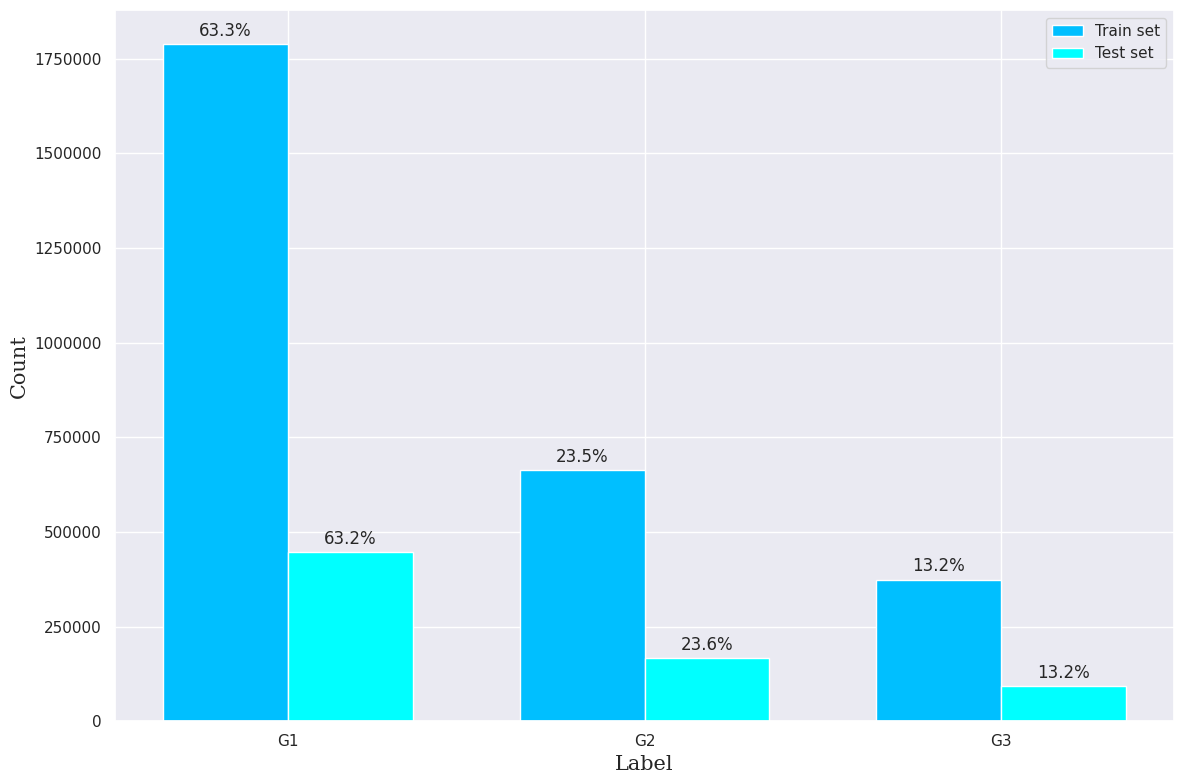

In [12]:
df_train = train.select('LABEL').toPandas()
df_test = test.select('LABEL').toPandas()

label_train = list(df_train.LABEL.value_counts())
label_test = list(df_test.LABEL.value_counts())

rate_train = [round(x * 100 / sum(label_train), 1) for x in label_train]
rate_test = [round(x * 100 / sum(label_test), 1) for x in label_test]

labels = ['G1', 'G2', 'G3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(x - width/2, label_train, width, label='Train set', color ='#00BFFF')
rects2 = ax.bar(x + width/2, label_test, width, label='Test set', color ='#00FFFF')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel_train(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_train[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel_test(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_test[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_train(rects1)
autolabel_test(rects2)
# Adding Xticks
plt.xlabel('Label', fontsize = 15, fontfamily='serif')
plt.ylabel('Count', fontsize = 15, fontfamily='serif')

fig.tight_layout()
plt.show()

## Build and evaluate models

### Logistic regression

#### Training model

In [13]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [14]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [15]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [16]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [17]:
LR = LogisticRegression(featuresCol='features',
                        # featuresCol = 'scaledFeatures'
                        labelCol='LABEL')

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler,
                            # scaler,
                            LR])

In [ ]:
%%time
model_LR = pipeline.fit(train)

CPU times: user 48.7 ms, sys: 12.9 ms, total: 61.6 ms
Wall time: 2min 5s


#### Evaluate model

##### Train

In [ ]:
Trained = model_LR.transform(train)
Trained.show(truncate=False)
Trained.count()

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+-----------------------------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------+----------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|ORIGINVec        |DESTVec          |features                                                                     |rawPrediction                                                |probability                                                  |prediction|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----

2827565

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|2645235|
|       1.0| 159283|
|       2.0|  23047|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6530    0.9652    0.7790   1789610
           1     0.4165    0.0999    0.1612    663846
           2     0.3241    0.0200    0.0376    374109

    accuracy                         0.6370   2827565
   macro avg     0.4645    0.3617    0.3259   2827565
weighted avg     0.5540    0.6370    0.5359   2827565



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 63.70227%
F1-Micro: 63.70227%
F1-Macro: 32.59364%


##### Test

In [ ]:
Tested = model_LR.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|         600

707417

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|662025|
|       1.0| 39689|
|       2.0|  5703|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6517    0.9653    0.7781    446961
           1     0.4123    0.0980    0.1584    166929
           2     0.3275    0.0200    0.0376     93527

    accuracy                         0.6356    707417
   macro avg     0.4638    0.3611    0.3247    707417
weighted avg     0.5523    0.6356    0.5340    707417



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 63.56421%
F1-Micro: 63.56421%
F1-Macro: 32.46995%


#### Save & load model

In [ ]:
model_LR.write().overwrite().save('/content/drive/MyDrive/dataset/Model/LR')

In [ ]:
model_LR_load = PipelineModel.load('/content/drive/MyDrive/dataset/Model/LR')

### Decision tree

#### Training model

In [18]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [19]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [20]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [21]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [22]:
DT = DecisionTreeClassifier(maxDepth=16, featuresCol='features', labelCol='LABEL')

In [23]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, DT])

In [ ]:
%%time
model_DT = pipeline.fit(train)

#### Evaluate model

##### Train

In [ ]:
Trained = model_DT.transform(train)
Trained.show()
Trained.count()

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

##### Test

In [ ]:
Tested = model_DT.transform(test)
Tested.show()
Tested.count()

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average='micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average='macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

#### Save & load model

In [ ]:
model_DT.write().overwrite().save('/content/drive/MyDrive/dataset/Model/DT')


In [ ]:
model_DT_load = PipelineModel.load('/content/drive/MyDrive/dataset/Model/DT')

In [ ]:
import shutil
import os

# Define the path to the models directory
models_dir = '/content/drive/MyDrive/dataset/Model'

# Define the output path for the zip file in the content directory
output_zip_path = '/content/Models'

# Create a zip archive of the models directory
shutil.make_archive(output_zip_path, 'zip', models_dir)

print(f"Models successfully zipped to {output_zip_path}.zip")
print("You can now download this file from the Colab file browser (left panel) or use the following command:")
print("!cp /content/Models.zip /content/drive/MyDrive/")

### Random forest

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
RF = RandomForestClassifier(maxDepth=10, numTrees = 3, featuresCol='features', labelCol='LABEL')#

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, RF])

In [ ]:
%%time
model_RF = pipeline.fit(train)

CPU times: user 84.3 ms, sys: 16.5 ms, total: 101 ms
Wall time: 6min 56s


#### Evaluate model

##### Train

In [ ]:
Trained = model_RF.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|        1235

2827565

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|2827517|
|       1.0|     46|
|       2.0|      2|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6329    1.0000    0.7752   1789610
           1     0.8043    0.0001    0.0001    663846
           2     1.0000    0.0000    0.0000    374109

    accuracy                         0.6329   2827565
   macro avg     0.8124    0.3334    0.2584   2827565
weighted avg     0.7217    0.6329    0.4907   2827565



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 63.29280%
F1-Micro: 63.29280%
F1-Macro: 25.84418%


##### Test

In [ ]:
Tested = model_RF.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|         600

707417

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|707406|
|       1.0|    11|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6318    1.0000    0.7744    446961
           1     0.6364    0.0000    0.0001    166929
           2     0.0000    0.0000    0.0000     93527

    accuracy                         0.6318    707417
   macro avg     0.4227    0.3333    0.2582    707417
weighted avg     0.5494    0.6318    0.4893    707417



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 63.18254%
F1-Micro: 63.18254%
F1-Macro: 25.81533%


#### Save & load model

In [ ]:
model_RF.write().overwrite().save('/content/drive/MyDrive/dataset/Model/RF')

In [ ]:
model_RF_load = PipelineModel.load('/content/drive/MyDrive/dataset/Model/RF')

### Naive Bayes

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
NB = NaiveBayes(featuresCol='features', labelCol='LABEL', smoothing=0.0003, modelType="multinomial")

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                            oneHotEncoder,
                            assembler, NB])

In [ ]:
%%time
model_NB = pipeline.fit(train)

CPU times: user 29.3 ms, sys: 6 ms, total: 35.3 ms
Wall time: 44.3 s


#### Evaluate model

##### Train

In [ ]:
Trained = model_NB.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|        1235

2827565

In [ ]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1266680|
|       1.0|  76306|
|       2.0|1484579|
+----------+-------+



In [ ]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL,
                            predicted_train_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6702    0.4744    0.5556   1789610
           1     0.3133    0.0360    0.0646    663846
           2     0.1538    0.6104    0.2457    374109

    accuracy                         0.3895   2827565
   macro avg     0.3791    0.3736    0.2886   2827565
weighted avg     0.5181    0.3895    0.3993   2827565



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'],
                  predicted_train_score['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 38.94726%
F1-Micro: 38.94726%
F1-Macro: 28.86315%


##### Test

In [ ]:
Tested = model_NB.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|         600

707417

In [ ]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|317639|
|       1.0| 19195|
|       2.0|370583|
+----------+------+



In [ ]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL,
                            predicted_test_score.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6682    0.4749    0.5552    446961
           1     0.3094    0.0356    0.0638    166929
           2     0.1539    0.6097    0.2457     93527

    accuracy                         0.3890    707417
   macro avg     0.3772    0.3734    0.2883    707417
weighted avg     0.5156    0.3890    0.3983    707417



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'],
                  predicted_test_score['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 38.90478%
F1-Micro: 38.90478%
F1-Macro: 28.82524%


#### Save & load model

In [ ]:
model_NB.write().overwrite().save('/content/drive/MyDrive/dataset/Model/NB')

In [ ]:
model_NB_load = PipelineModel.load('/content/drive/MyDrive/dataset/Model/NB')

### XGBoost

#### Training model

In [ ]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [ ]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [ ]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec',
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
XGB = SparkXGBClassifier(features_col='features', label_col='LABEL')

In [ ]:
pipeline = Pipeline(stages=[stringIndexer,
                                    oneHotEncoder,
                                    assembler,
                                    XGB])

In [ ]:
%%time
model_XGB = pipeline.fit(train)

INFO:XGBoost-PySpark:Running xgboost-3.1.2 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 3, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Could not recover from a failed barrier ResultStage. Most recent failure reason: Stage failed because barrier task ResultTask(377, 0) finished unsuccessfully.
org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:124)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:86)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:80)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:386)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:105)
	... 15 more

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:2228)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3054)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)


#### Evaluate model

##### Train

In [ ]:
Trained_xgb = model_XGB.transform(train)
Trained_xgb.show()
Trained_xgb.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|        1235

2827565

In [ ]:
Trained_xgb.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1266680|
|       1.0|  76306|
|       2.0|1484579|
+----------+-------+



In [ ]:
predicted_train_xgb = Trained_xgb.select("prediction", 'LABEL')
predicted_train_score_xgb = predicted_train_xgb.toPandas()

print(classification_report(predicted_train_score_xgb.LABEL,
                            predicted_train_score_xgb.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6702    0.4744    0.5556   1789610
           1     0.3133    0.0360    0.0646    663846
           2     0.1538    0.6104    0.2457    374109

    accuracy                         0.3895   2827565
   macro avg     0.3791    0.3736    0.2886   2827565
weighted avg     0.5181    0.3895    0.3993   2827565



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained_xgb)
f1_mic = f1_score(predicted_train_score_xgb['LABEL'],
                  predicted_train_score_xgb['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_train_score_xgb['LABEL'],
                  predicted_train_score_xgb['prediction'],
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 38.94726%
F1-Micro: 38.94726%
F1-Macro: 28.86315%


##### Test

In [ ]:
Tested_xgb = model_XGB.transform(test)
Tested_xgb.show()
Tested_xgb.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|3/1/2024_9E_ABE_A...|      1|    3|           1|          5|               9E|   ABE| ATL|   692.0|         600

707417

In [ ]:
Tested_xgb.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|317639|
|       1.0| 19195|
|       2.0|370583|
+----------+------+



In [ ]:
predicted_test_xgb = Tested_xgb.select("prediction", 'LABEL')
predicted_test_score_xgb = predicted_test_xgb.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score_xgb.LABEL,
                            predicted_test_score_xgb.prediction,
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6682    0.4749    0.5552    446961
           1     0.3094    0.0356    0.0638    166929
           2     0.1539    0.6097    0.2457     93527

    accuracy                         0.3890    707417
   macro avg     0.3772    0.3734    0.2883    707417
weighted avg     0.5156    0.3890    0.3983    707417



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested_xgb)
f1_mic = f1_score(predicted_test_score_xgb['LABEL'],
                  predicted_test_score_xgb['prediction'],
                  average = 'micro')
f1_mac = f1_score(predicted_test_score_xgb['LABEL'],
                  predicted_test_score_xgb['prediction'],
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 38.90478%
F1-Micro: 38.90478%
F1-Macro: 28.82524%


#### Save & load model

In [ ]:
model_XGB.write().overwrite().save('/content/drive/MyDrive/dataset/Model/XGB')

In [ ]:
model_XGB_load = PipelineModel.load('/content/drive/MyDrive/dataset/Model/XGB')